In [ ]:

# Project Paths & Config
import os

BASE_DIR = "./core-backend/"

MODEL_PATH = os.path.join(BASE_DIR, "model", "pokemon_card_model.pth")
IDX2ID_PATH = os.path.join(BASE_DIR, "label", "idx2id.json")
ID2IDX_PATH = os.path.join(BASE_DIR, "label", "id2idx.json")
MANIFEST_PATH = os.path.join(BASE_DIR,  "data", "ALL_Pokemon_Cards_manifest_with_base64.csv")


PARENT_DIR = './Users/'
DATA_DIR = f"{PARENT_DIR}/Data"
IMAGES_DIR = f"{PARENT_DIR}/images"
ALL_IMAGES_FOLDER = f"{IMAGES_DIR}/ALL_Pokemon_Cards"
STANDARD_IMAGES_FOLDER = f"{IMAGES_DIR}/ALL_Pokemon_Cards_standard"
MANIFEST_CSV = f"{DATA_DIR}/ALL_Pokemon_Cards_manifest.csv"
CARDS_CSV = f"{DATA_DIR}/pokemon-tcg-data-master 1999-2023.csv"
CARDS_IMAGES_CSV = f"{DATA_DIR}/pokemon-cards.csv"

STANDARD_SIZE = (224, 224)
STANDARD_FORMAT = 'JPEG'
STANDARD_COLOR_MODE = 'RGB'


In [42]:
# Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import hashlib
import requests
from io import BytesIO
from collections import Counter
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import base64
import os
import json


In [3]:
# Load both datasets
df_cards = pd.read_csv(CARDS_CSV)
df_imgs = pd.read_csv(CARDS_IMAGES_CSV)


In [4]:
# Check for data issues (nulls in key fields)
key_fields = ['id', 'name', 'set', 'series', 'types', 'supertype', 'subtypes', 'hp', 'rarity', 'attacks', 'abilities']
print("Null value count in key fields:")
print(df_cards[key_fields].isnull().sum())
print("\nNull value count in image dataset (sample):")
print(df_imgs.isnull().sum())


Null value count in key fields:
id               0
name             0
set              0
series           0
types         2672
supertype        0
subtypes       174
hp            2636
rarity         295
attacks       2663
abilities    13744
dtype: int64

Null value count in image dataset (sample):
id           0
image_url    0
caption      0
name         0
hp           0
set_name     0
dtype: int64


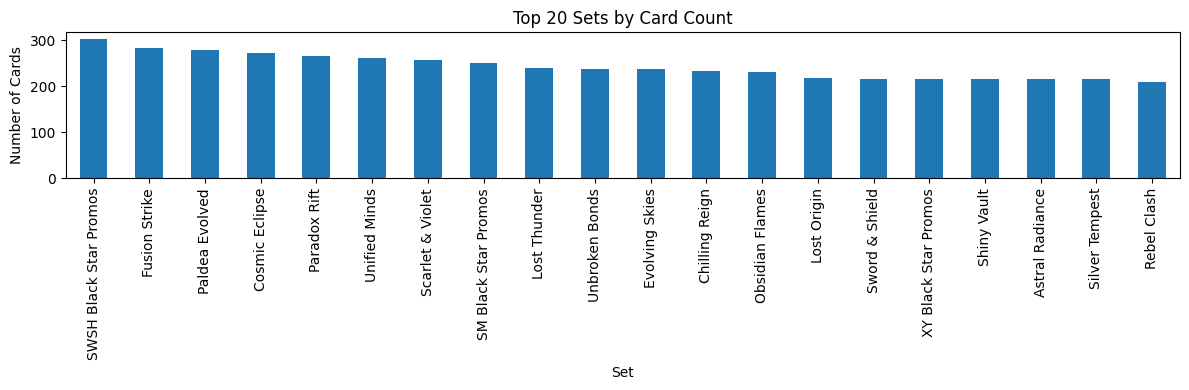

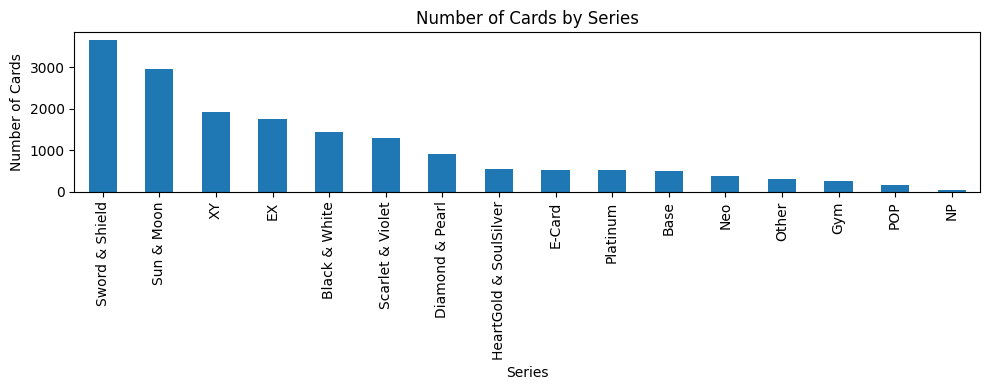

In [5]:
# EDA

# Number of cards by release/set and by series
plt.figure(figsize=(12, 4))
df_cards['set'].value_counts().head(20).plot(kind='bar')
plt.title('Top 20 Sets by Card Count')
plt.xlabel('Set')
plt.ylabel('Number of Cards')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
df_cards['series'].value_counts().plot(kind='bar')
plt.title('Number of Cards by Series')
plt.xlabel('Series')
plt.ylabel('Number of Cards')
plt.tight_layout()
plt.show()


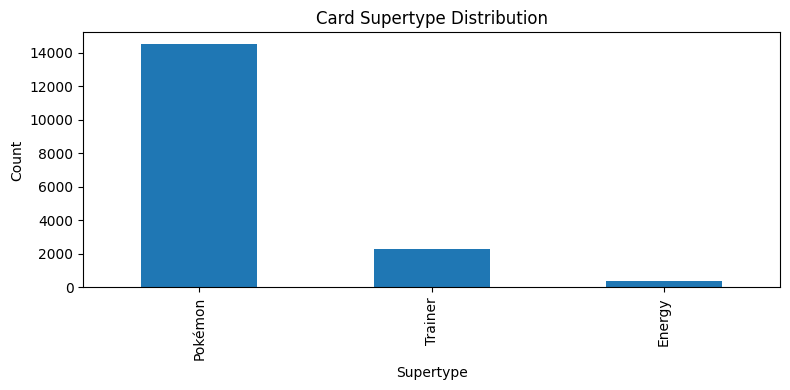

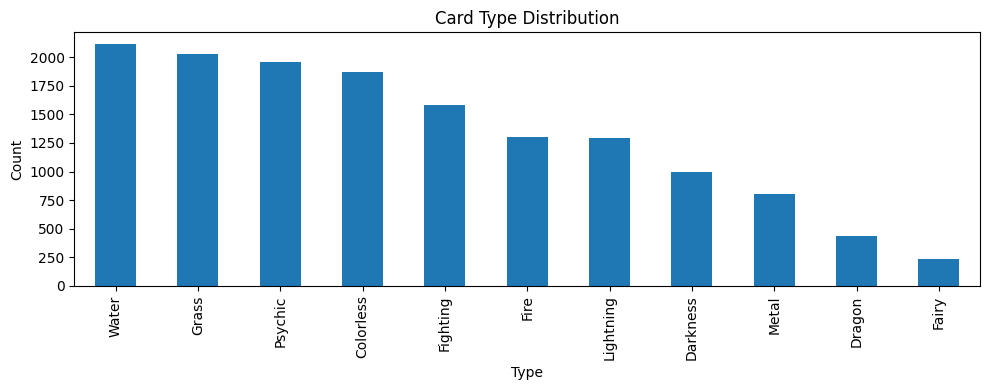

In [6]:
# Card types and supertypes distribution

plt.figure(figsize=(8,4))
df_cards['supertype'].value_counts().plot(kind='bar')
plt.title('Card Supertype Distribution')
plt.xlabel('Supertype')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

if df_cards['types'].dtype == object:
    df_cards['types_str'] = df_cards['types'].astype(str)
    all_types = df_cards['types_str'].str.strip('[]').str.replace("'", "").str.split(', ')
    type_counts = pd.Series([t for sublist in all_types for t in sublist if t != 'nan']).value_counts()
    plt.figure(figsize=(10,4))
    type_counts.plot(kind='bar')
    plt.title('Card Type Distribution')
    plt.xlabel('Type')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


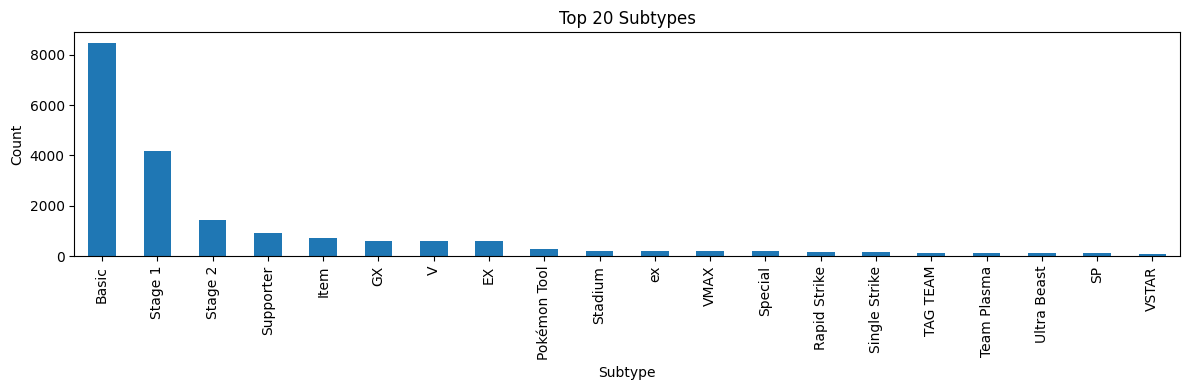

In [7]:
# Subtype breakdown

if df_cards['subtypes'].dtype == object:
    df_cards['subtypes_str'] = df_cards['subtypes'].astype(str)
    all_subtypes = df_cards['subtypes_str'].str.strip('[]').str.replace("'", "").str.split(', ')
    subtype_counts = pd.Series([t for sublist in all_subtypes for t in sublist if t != 'nan']).value_counts()
    plt.figure(figsize=(12,4))
    subtype_counts.head(20).plot(kind='bar')
    plt.title('Top 20 Subtypes')
    plt.xlabel('Subtype')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


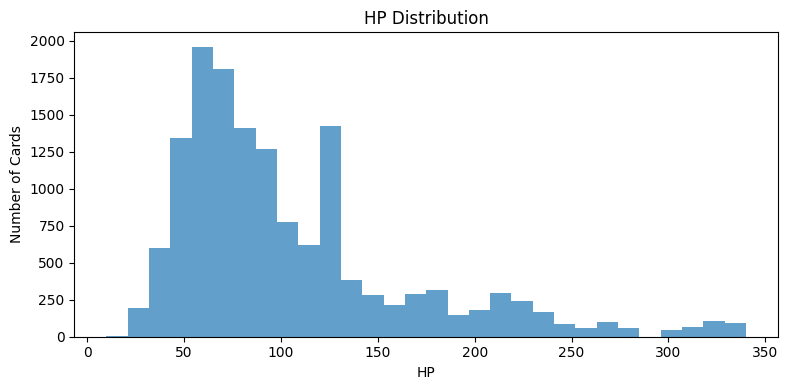

In [8]:
# HP Distribution

plt.figure(figsize=(8,4))
df_cards['hp'] = pd.to_numeric(df_cards['hp'], errors='coerce')
df_cards['hp'].dropna().astype(int).plot(kind='hist', bins=30, alpha=0.7)
plt.title('HP Distribution')
plt.xlabel('HP')
plt.ylabel('Number of Cards')
plt.tight_layout()
plt.show()


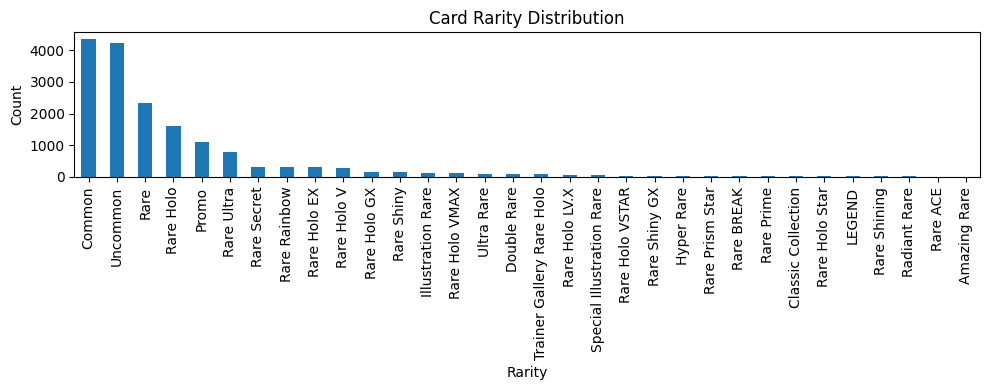

In [9]:
# Rarity analysis

plt.figure(figsize=(10,4))
df_cards['rarity'].value_counts().plot(kind='bar')
plt.title('Card Rarity Distribution')
plt.xlabel('Rarity')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


Average number of attacks per card: 1.3911600279524807
Average number of abilities per card: 0.20055904961565338


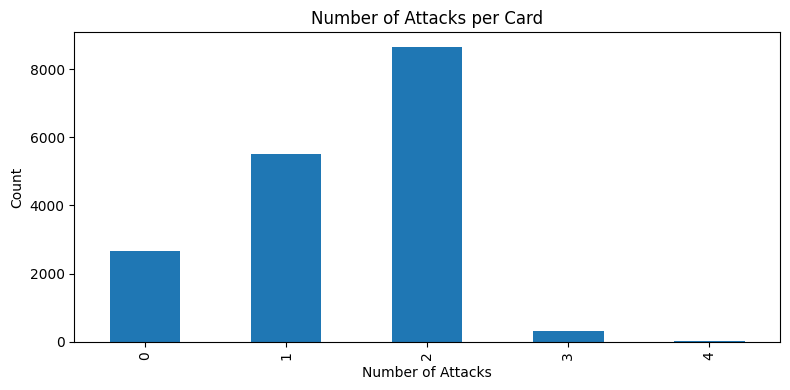

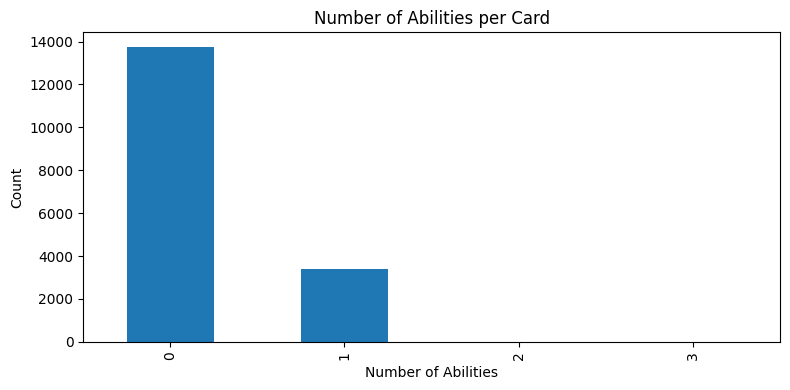

In [10]:
# Card abilities/attacks: Analyze average number of attacks or abilities per card

df_cards['num_attacks'] = df_cards['attacks'].apply(lambda x: len(eval(x)) if pd.notnull(x) and x.startswith('[') else 0)
df_cards['num_abilities'] = df_cards['abilities'].apply(lambda x: len(eval(x)) if pd.notnull(x) and x.startswith('[') else 0)

print("Average number of attacks per card:", df_cards['num_attacks'].mean())
print("Average number of abilities per card:", df_cards['num_abilities'].mean())

plt.figure(figsize=(8,4))
df_cards['num_attacks'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Attacks per Card')
plt.xlabel('Number of Attacks')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
df_cards['num_abilities'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Abilities per Card')
plt.xlabel('Number of Abilities')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [11]:
# Normalize names and set columns for reliable merging

def normalize_string(s):
    if pd.isnull(s): return ''
    return str(s).lower().strip()

df_cards['name_norm'] = df_cards['name'].apply(normalize_string)
df_cards['set_norm'] = df_cards['set'].apply(normalize_string)
df_cards['key'] = df_cards['name_norm'] + '|' + df_cards['set_norm']

df_imgs['name_norm'] = df_imgs['name'].apply(normalize_string)
df_imgs['set_norm'] = df_imgs['set_name'].apply(normalize_string)
df_imgs['key'] = df_imgs['name_norm'] + '|' + df_imgs['set_norm']


In [12]:

df_base = df_cards[df_cards['set_norm'] == 'base'].copy()
df_base_img = df_base.merge(df_imgs[['key', 'image_url']], on='key', how='left')

n_total = len(df_base_img)
n_with_image = df_base_img['image_url'].notna().sum()
coverage_pct = n_with_image / n_total * 100

print(f"Base set total cards: {n_total}")
print(f"Cards with images: {n_with_image}")
print(f"Image coverage: {coverage_pct:.2f}%")

missing_images = df_base_img[df_base_img['image_url'].isna()]
if missing_images.empty:
    print("All Base set cards have images!")
else:
    print("Base set cards missing images:")
    display(missing_images[['id', 'name', 'set']])


Base set total cards: 102
Cards with images: 69
Image coverage: 67.65%
Base set cards missing images:


,id,name,set
69,base1-70,Clefairy Doll,Base
70,base1-71,Computer Search,Base
71,base1-72,Devolution Spray,Base
72,base1-73,Impostor Professor Oak,Base
73,base1-74,Item Finder,Base
74,base1-75,Lass,Base
75,base1-76,Pokémon Breeder,Base
76,base1-77,Pokémon Trader,Base
77,base1-78,Scoop Up,Base
78,base1-79,Super Energy Removal,Base


In [13]:
# Merge all cards with image links by id
df_merged = df_cards.merge(df_imgs[['id', 'image_url']], on='id', how='left')
set_stats = (
    df_merged
    .groupby('set')[['name', 'image_url']]
    .agg(
        total_cards=('name', 'count'),
        cards_with_image=('image_url', lambda x: x.notna().sum())
    )
    .reset_index()
)
set_stats['image_coverage_pct'] = 100 * set_stats['cards_with_image'] / set_stats['total_cards']
set_stats_sorted = set_stats.sort_values('image_coverage_pct', ascending=False)

print("Top 25 Sets with Highest Image Coverage:")
for idx, row in set_stats_sorted.head(25).iterrows():
    print(f"{idx+1:2d}. {row['set']}: {row['cards_with_image']} / {row['total_cards']} cards ({row['image_coverage_pct']:.2f}% coverage)")


Top 25 Sets with Highest Image Coverage:
79. McDonald's Collection 2011: 12 / 12 cards (100.00% coverage)
81. McDonald's Collection 2014: 12 / 12 cards (100.00% coverage)
88. McDonald's Collection 2022: 15 / 15 cards (100.00% coverage)
87. McDonald's Collection 2021: 25 / 25 cards (100.00% coverage)
103. POP Series 6: 17 / 17 cards (100.00% coverage)
104. POP Series 7: 17 / 17 cards (100.00% coverage)
106. POP Series 9: 17 / 17 cards (100.00% coverage)
86. McDonald's Collection 2019: 12 / 12 cards (100.00% coverage)
85. McDonald's Collection 2018: 12 / 12 cards (100.00% coverage)
114. Pokémon Futsal Collection: 5 / 5 cards (100.00% coverage)
116. Pokémon Rumble: 16 / 16 cards (100.00% coverage)
84. McDonald's Collection 2017: 12 / 12 cards (100.00% coverage)
83. McDonald's Collection 2016: 12 / 12 cards (100.00% coverage)
35. Detective Pikachu: 18 / 18 cards (100.00% coverage)
82. McDonald's Collection 2015: 12 / 12 cards (100.00% coverage)
80. McDonald's Collection 2012: 12 / 12 cards

In [14]:
# Check total image coverage

total_cards = df_merged['name'].count()
total_with_images = df_merged['image_url'].notna().sum()
total_coverage_pct = 100 * total_with_images / total_cards
print("\n==== TOTAL IMAGE COVERAGE ACROSS ALL SETS ====")
print(f"Total cards: {total_cards}")
print(f"Cards with images: {total_with_images}")
print(f"Overall image coverage: {total_coverage_pct:.2f}%")



==== TOTAL IMAGE COVERAGE ACROSS ALL SETS ====
Total cards: 17172
Cards with images: 13139
Overall image coverage: 76.51%


In [15]:
#Data Imbalance

card_counts = df_merged.groupby('key').size()
print(card_counts.describe())
print("Cards with <3 images:", (card_counts < 3).sum())


count    14417.000000
mean         1.191094
std          0.561094
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         28.000000
dtype: float64
Cards with <3 images: 13919


In [16]:
#Check URL access

sample_urls = df_merged['image_url'].dropna().sample(5)
for url in sample_urls:
    try:
        img = Image.open(BytesIO(requests.get(url).content))
        img.verify()
        print(f"OK: {url}")
    except Exception as e:
        print(f"Corrupted or inaccessible: {url} ({e})")


OK: https://images.pokemontcg.io/swsh4/9_hires.png
OK: https://images.pokemontcg.io/bw7/66_hires.png
OK: https://images.pokemontcg.io/xy5/27_hires.png
OK: https://images.pokemontcg.io/bwp/BW91_hires.png
OK: https://images.pokemontcg.io/swsh7/211_hires.png


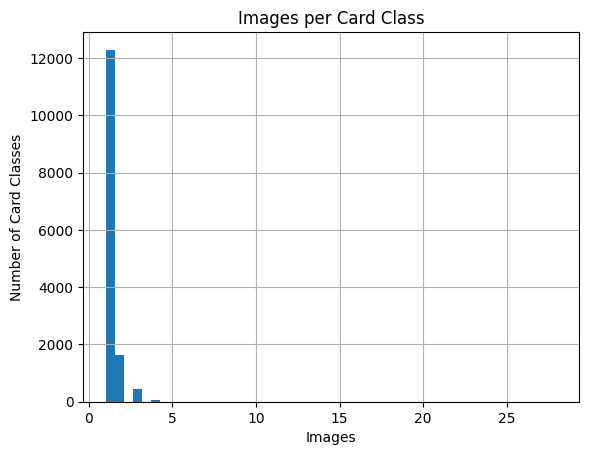

In [17]:

card_counts.hist(bins=50)
plt.title('Images per Card Class')
plt.xlabel('Images')
plt.ylabel('Number of Card Classes')
plt.show()


In [18]:

meta_df = pd.read_csv(CARDS_CSV)
image_df = pd.read_csv(CARDS_IMAGES_CSV)
print("Metadata - Duplicated IDs:", meta_df['id'].duplicated().sum())
print("Images - Duplicated IDs:", image_df['id'].duplicated().sum())


Metadata - Duplicated IDs: 0
Images - Duplicated IDs: 0


In [19]:
#IDs in images but NOT in metadata

img_not_in_meta = set(image_df['id']) - set(meta_df['id'])
print("IDs in images but NOT in metadata:", len(img_not_in_meta))
print(img_not_in_meta)


IDs in images but NOT in metadata: 0
set()


In [20]:
# After merge:

merged_df = pd.merge(meta_df, image_df, on="id", how="inner")
print("Rows in merged dataset:", len(merged_df))
print(merged_df.isnull().sum())


Rows in merged dataset: 13139
id                            0
set                           0
series                        0
publisher                     0
generation                    0
release_date                  0
artist                        5
name_x                        0
set_num                       0
types                         0
supertype                     0
subtypes                      0
level                     10735
hp_x                          0
evolvesFrom                7573
evolvesTo                  7668
abilities                 10039
attacks                      24
weaknesses                  341
retreatCost                 726
convertedRetreatCost        726
rarity                      235
flavorText                 4476
nationalPokedexNumbers        1
legalities                    0
resistances                9125
rules                     10758
regulationMark            10310
ancientTrait              13080
image_url                     0
caption   

In [21]:
# Or group by set/series for distribution by set

card_counts = merged_df['id'].value_counts()
print(card_counts.describe())
set_counts = merged_df['set'].value_counts()
print(set_counts)


count    13139.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: count, dtype: float64
set
SWSH Black Star Promos       269
SM Black Star Promos         247
Fusion Strike                245
Cosmic Eclipse               229
Unified Minds                216
                            ... 
EX Trainer Kit 2 Minun         7
EX Trainer Kit 2 Plusle        7
EX Trainer Kit Latias          7
EX Trainer Kit Latios          7
Pokémon Futsal Collection      5
Name: count, Length: 147, dtype: int64


In [22]:
# Find duplicate image URLs

dupe_image_urls = df_merged[df_merged.duplicated(subset=['image_url'], keep=False)]
sample_dupe = dupe_image_urls.groupby('image_url').filter(lambda x: len(x) > 1)
if not sample_dupe.empty:
    first_image_url = sample_dupe['image_url'].iloc[0]
    print("Sample duplicate image_url group:")
    display(sample_dupe[sample_dupe['image_url'] == first_image_url])
else:
    print("No duplicate image_url found.")


No duplicate image_url found.


In [23]:
#Merge datasets on 'id'
meta_df = meta_df.drop_duplicates(subset=['id'])

# Merge on 'id'
merged_df = pd.merge(meta_df, image_df, how='inner', on='id', suffixes=('', '_img'))

print("Merged shape:", merged_df.shape)
print(merged_df[['id', 'set', 'name', 'hp', 'rarity', 'types']].head())


Merged shape: (13139, 34)
        id   set       name     hp     rarity          types
0  base1-1  Base   Alakazam   80.0  Rare Holo    ['Psychic']
1  base1-2  Base  Blastoise  100.0  Rare Holo      ['Water']
2  base1-3  Base    Chansey  120.0  Rare Holo  ['Colorless']
3  base1-4  Base  Charizard  120.0  Rare Holo       ['Fire']
4  base1-5  Base   Clefairy   40.0  Rare Holo  ['Colorless']


In [24]:
# Use ALL cards 
all_cards = merged_df.copy()
print("Total cards (all sets):", all_cards.shape[0])


Total cards (all sets): 13139


In [25]:
#Download Card Images

os.makedirs(ALL_IMAGES_FOLDER, exist_ok=True)
missing_images = []
downloaded_count = 0

for idx, row in all_cards.iterrows():
    card_id = row['id']
    image_url = row.get('image_url')
    output_path = os.path.join(ALL_IMAGES_FOLDER, f"{card_id}.jpg")
    if not pd.isna(image_url):
        try:
            resp = requests.get(image_url, timeout=10)
            if resp.status_code == 200:
                with open(output_path, 'wb') as f:
                    f.write(resp.content)
                downloaded_count += 1
            else:
                missing_images.append(card_id)
        except Exception as e:
            print(f"Error downloading {card_id}: {e}")
            missing_images.append(card_id)
    else:
        missing_images.append(card_id)
print(f"Total images attempted: {all_cards.shape[0]}")
print(f"Images downloaded successfully: {downloaded_count}")
print(f"Images failed to download: {len(missing_images)}")
print("Failed image IDs:", missing_images)


Total images attempted: 13139
Images downloaded successfully: 13088
Images failed to download: 51
Failed image IDs: ['xyp-XY39', 'xyp-XY46', 'xyp-XY68', 'mcd14-1', 'mcd14-2', 'mcd14-3', 'mcd14-4', 'mcd14-5', 'mcd14-6', 'mcd14-7', 'mcd14-8', 'mcd14-9', 'mcd14-10', 'mcd14-11', 'mcd14-12', 'mcd15-1', 'mcd15-2', 'mcd15-3', 'mcd15-4', 'mcd15-5', 'mcd15-6', 'mcd15-7', 'mcd15-8', 'mcd15-9', 'mcd15-10', 'mcd15-11', 'mcd15-12', 'mcd17-1', 'mcd17-2', 'mcd17-3', 'mcd17-4', 'mcd17-5', 'mcd17-6', 'mcd17-7', 'mcd17-8', 'mcd17-9', 'mcd17-10', 'mcd17-11', 'mcd17-12', 'mcd18-1', 'mcd18-2', 'mcd18-3', 'mcd18-4', 'mcd18-5', 'mcd18-6', 'mcd18-7', 'mcd18-8', 'mcd18-9', 'mcd18-10', 'mcd18-11', 'mcd18-12']


In [26]:
#Link Images and Metadata

manifest = []

for idx, row in all_cards.iterrows():
    card_id = row['id']
    image_path = os.path.join(ALL_IMAGES_FOLDER, f"{card_id}.jpg")
    if os.path.isfile(image_path):
        manifest.append({
            'id': card_id,
            'set': row['set'],
            'name': row['name'],
            'hp': row.get('hp', ''),
            'rarity': row.get('rarity', ''),
            'types': row.get('types', ''),
            'image_path': image_path
        })
manifest_df = pd.DataFrame(manifest)
os.makedirs(DATA_DIR, exist_ok=True)
manifest_df.to_csv(MANIFEST_CSV, index=False)
print(f"Manifest created with {len(manifest_df)} entries")


Manifest created with 13088 entries


In [27]:
#Deduplication & Quality Check

all_images = [f for f in os.listdir(ALL_IMAGES_FOLDER) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
hashes = {}; duplicates = []; corrupt = []; non_rgb = []
for fname in all_images:
    fpath = os.path.join(ALL_IMAGES_FOLDER, fname)
    try:
        with open(fpath, 'rb') as f:
            filehash = hashlib.md5(f.read()).hexdigest()
        if filehash in hashes:
            duplicates.append(fname)
        else:
            hashes[filehash] = fname
        with Image.open(fpath) as img:
            if img.mode != 'RGB':
                non_rgb.append(fname)
    except Exception as e:
        corrupt.append(fname)
print("Deduplication/Quality Check Summary:")
print(f"Total images checked: {len(all_images)}")
print(f"Duplicate images found: {len(duplicates)} - {duplicates}")
print(f"Corrupt/unopenable images: {len(corrupt)} - {corrupt}")


Deduplication/Quality Check Summary:
Total images checked: 13088
Duplicate images found: 0 - []
Corrupt/unopenable images: 0 - []


In [28]:
#Color modes check
color_modes = []
for fname in all_images:
    fpath = os.path.join(ALL_IMAGES_FOLDER, fname)
    try:
        with Image.open(fpath) as img:
            color_modes.append(img.mode)
    except Exception as e:
        print(f"Error with {fname}: {e}")
mode_counts = Counter(color_modes)
print("Color mode counts in folder:")
for mode, count in mode_counts.items():
    print(f"{mode}: {count} images")


Color mode counts in folder:
RGBA: 8905 images
RGB: 4183 images


In [53]:
#Standardization - Resize all images to 224x224 (standard for many models), convert to RGB, and save as JPEG

os.makedirs(STANDARD_IMAGES_FOLDER, exist_ok=True)
processed, skipped = 0, 0

for fname in all_images:
    fpath = os.path.join(ALL_IMAGES_FOLDER, fname)
    outpath = os.path.join(STANDARD_IMAGES_FOLDER, fname)
    try:
        with Image.open(fpath) as img:
            img = img.convert(STANDARD_COLOR_MODE)
            img = img.resize(STANDARD_SIZE)
            img.save(outpath, STANDARD_FORMAT)
        processed += 1
    except Exception as e:
        print(f"Skipping {fname}: {e}")
        skipped += 1
print("\nStandardization complete.")
#print(f"Resized images saved to: {STANDARD_IMAGES_FOLDER}")
print(f"Total processed: {processed}, Skipped: {skipped}")
print(f"Size: {STANDARD_SIZE}, Format: {STANDARD_FORMAT}, Color mode: {STANDARD_COLOR_MODE}")



Standardization complete.
Total processed: 13088, Skipped: 0
Size: (224, 224), Format: JPEG, Color mode: RGB


In [30]:
# Create manifest 
import pandas as pd
import os

standard_manifest = []
for fname in os.listdir(STANDARD_IMAGES_FOLDER):
    if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        card_id = os.path.splitext(fname)[0]
        image_path = os.path.join(STANDARD_IMAGES_FOLDER, fname)
        # You may need to merge metadata here, e.g., from all_cards or merged_df, by card_id!
        meta = all_cards[all_cards['id'] == card_id]
        if not meta.empty:
            row = meta.iloc[0]
            standard_manifest.append({
                'id': card_id,
                'set': row.get('set', ''),
                'name': row.get('name', ''),
                'hp': row.get('hp', ''),
                'rarity': row.get('rarity', ''),
                'types': row.get('types', ''),
                'image_path': image_path
            })
standard_manifest_df = pd.DataFrame(standard_manifest)
standard_manifest_path = os.path.join(DATA_DIR, 'ALL_Pokemon_Cards_standard_manifest.csv')
standard_manifest_df.to_csv(standard_manifest_path, index=False)
print(f"Standardized manifest created with {len(standard_manifest_df)} entries")

Standardized manifest created with 13088 entries


In [31]:

# Use all images for training (no validation/test split)
train_df = standard_manifest_df.copy()
print("Training DataFrame shape:", train_df.shape)


Training DataFrame shape: (13088, 7)


In [32]:

# Label mapping
card_ids = train_df['id'].unique()
id2idx = {card_id: idx for idx, card_id in enumerate(card_ids)}
idx2id = {idx: card_id for card_id, idx in id2idx.items()}
train_df['label'] = train_df['id'].map(id2idx)


In [33]:
# Define PyTorch Dataset

class CardDataset(Dataset):
    def __init__(self, manifest_df, transform=None):
        self.data = manifest_df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = row['image_path']
        label = row['label']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


In [34]:
# Define Training Transforms

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.1, hue=0.03),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.08), ratio=(0.5, 2.0)),
])


In [35]:
# Build Training DataLoader 

batch_size = 32
train_dataset = CardDataset(train_df, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
print(f"Training DataLoader created with {len(train_df)} images.")


Training DataLoader created with 13088 images.


In [36]:
# Define Pretrained ResNet Model

num_classes = len(id2idx)
from torchvision.models import ResNet18_Weights
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False  # Freeze backbone
model.fc = nn.Linear(model.fc.in_features, num_classes)  # New classifier layer
for param in model.fc.parameters():
    param.requires_grad = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


In [37]:
# Set Up Optimizer and Loss 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [38]:
# Training Loop

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        train_correct += (outputs.argmax(1) == labels).sum().item()
        train_total += images.size(0)
    train_acc = train_correct / train_total
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss/train_total:.4f}, Train Acc: {train_acc:.4f}")


Epoch 1/10 - Train Loss: 13.4082, Train Acc: 0.0000
Epoch 2/10 - Train Loss: 7.3569, Train Acc: 0.0391
Epoch 3/10 - Train Loss: 5.2897, Train Acc: 0.1571
Epoch 4/10 - Train Loss: 3.8030, Train Acc: 0.3481
Epoch 5/10 - Train Loss: 2.6993, Train Acc: 0.5412
Epoch 6/10 - Train Loss: 1.9611, Train Acc: 0.6770
Epoch 7/10 - Train Loss: 1.4787, Train Acc: 0.7620
Epoch 8/10 - Train Loss: 1.1382, Train Acc: 0.8166
Epoch 9/10 - Train Loss: 0.9064, Train Acc: 0.8520
Epoch 10/10 - Train Loss: 0.7574, Train Acc: 0.8773


In [39]:
# Final Evaluation: Training Accuracy
model.eval()
train_correct, train_total = 0, 0
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        train_correct += (outputs.argmax(1) == labels).sum().item()
        train_total += images.size(0)
train_acc = train_correct / train_total
print(f"\nFinal Training Set Accuracy: {train_acc:.4f}")



Final Training Set Accuracy: 0.9362


In [54]:
# Save model
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model weights saved in MODEL_PATH")



Model weights saved in MODEL_PATH


In [55]:
#Save label mapping
with open(ID2IDX_PATH, "w") as f:
    json.dump(id2idx, f)
with open(IDX2ID_PATH, "w") as f:
    json.dump(idx2id, f)
print(f"Label mapping saved as ID2IDX_PATH and IDX2ID_PATH")

Label mapping saved as ID2IDX_PATH and IDX2ID_PATH


In [44]:
#Create Manifest with base64 images 
def image_to_base64(path):
    if isinstance(path, str) and os.path.exists(path):
        with open(path, "rb") as f:
            return base64.b64encode(f.read()).decode('utf-8')
    return ""
# Create a copy to avoid modifying the original DataFrame
manifest_base64_df = standard_manifest_df.copy()

# Convert image to base64 and create a new column
manifest_base64_df['base64_image'] = manifest_base64_df['image_path'].apply(image_to_base64)

# Optionally, drop the image_path column if you don't want it in the new file
manifest_base64_df = manifest_base64_df.drop(columns=['image_path'])

# Save to the required path
os.makedirs(os.path.dirname(MANIFEST_PATH), exist_ok=True)
manifest_base64_df.to_csv(MANIFEST_PATH, index=False)
print(f"Manifest with base64 images created with {len(manifest_base64_df)} entries.")


Manifest with base64 images created with 13088 entries.


In [ ]:
#select Image file and perform pre processing
test_image_path = "./CardTest/Naganadel.png"  # <--- Change to your test image path
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
img = Image.open(test_image_path).convert('RGB')
img_tensor = test_transform(img).unsqueeze(0) # (1, 3, 224, 224)
img_tensor = img_tensor.to(device)


In [50]:
#Predict with the Model

model.eval()
with torch.no_grad():
    outputs = model(img_tensor)
    _, predicted = outputs.max(1)
    predicted_idx = predicted.item()
    predicted_id = idx2id[predicted_idx]
print(f"Predicted Card ID: {predicted_id}")


Predicted Card ID: smp-SM125


In [51]:
#Retrieve Card Details

card_details = manifest_base64_df[manifest_base64_df['id'] == predicted_id].iloc[0]
print(f"Name: {card_details['name']}")
print(f"Set: {card_details['set']}")
print(f"HP: {card_details['hp']}")
print(f"Rarity: {card_details['rarity']}")
print(f"Types: {card_details['types']}")


Name: Naganadel-GX
Set: SM Black Star Promos
HP: 210.0
Rarity: Promo
Types: ['Psychic']


Official card image (from base64 in manifest):


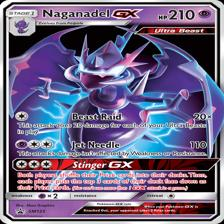

In [52]:
#display image
import base64
from io import BytesIO
from PIL import Image
from IPython.display import display

# Assuming card_details['base64_image'] contains the base64 string
base64_str = card_details['base64_image']

# Convert base64 string back to image
image_data = base64.b64decode(base64_str)
img = Image.open(BytesIO(image_data))

print("Official card image (from base64 in manifest):")
display(img)
